<a href="https://colab.research.google.com/github/rodrigosilvacio/data-repository/blob/main/Tech_Challenge_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# Importação de bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import plotly.express as px
import numpy as np
import warnings

# Ignorar todos os warnings
warnings.filterwarnings('ignore')

# Etapa 1: Leitura e tratamento dos dados
try:
    dados = pd.read_csv('ExpVinho.csv', encoding='latin1', sep=';')
except FileNotFoundError:
    print("Arquivo de dados não encontrado. Verifique o caminho do arquivo.")
    exit()



In [8]:
# Exibir as primeiras linhas para inspeção
print("Primeiras linhas do dataset:")
print(dados.head())

Primeiras linhas do dataset:
   Id                              PaÃ­s  1970  1970.1  1971  1971.1  1972  \
0   1                       AfeganistÃ£o     0       0     0       0     0   
1   2                     Ãfrica do Sul     0       0     0       0     0   
2   3  Alemanha, RepÃºblica DemocrÃ¡tica     0       0     0       0  4168   
3   4                             Angola     0       0     0       0     0   
4   5                           Anguilla     0       0     0       0     0   

   1972.1   1973  1973.1  ...  2019  2019.1  2020  2020.1  2021  2021.1  2022  \
0       0      0       0  ...     0       0     0       0    11      46     0   
1       0      0       0  ...    26      95     4      21     0       0     0   
2    2630  12000    8250  ...  3660   25467  6261   32605  2698    6741  7630   
3       0      0       0  ...   345    1065     0       0     0       0  4068   
4       0      0       0  ...     0       0     0       0     0       0     0   

   2022.1  2023

In [9]:
# Exibir as colunas do DataFrame
print("Colunas do arquivo:")
print(dados.columns)

Colunas do arquivo:
Index(['Id', 'PaÃ­s', '1970', '1970.1', '1971', '1971.1', '1972', '1972.1',
       '1973', '1973.1',
       ...
       '2019', '2019.1', '2020', '2020.1', '2021', '2021.1', '2022', '2022.1',
       '2023', '2023.1'],
      dtype='object', length=110)


In [10]:
# Etapa 2: Limpeza e tratamento dos dados
# Renomear a coluna 'PaÃ­s' para 'Pais'
dados = dados.rename(columns={'PaÃ­s': 'Pais'})

# Filtrar apenas as colunas relevantes: País, anos de quantidade e anos de valor
quantidade_cols = [col for col in dados.columns if not '.1' in col and col.isdigit()]
valor_cols = [col for col in dados.columns if '.1' in col and col.split('.')[0].isdigit()]

# Converter os dados de formato wide para long (melt)
# Quantidade
dados_quantidade = dados.melt(id_vars=['Id', 'Pais'], value_vars=quantidade_cols,
                              var_name='Ano', value_name='Quantidade_Litros')

# Valor em USD
dados_valor = dados.melt(id_vars=['Id', 'Pais'], value_vars=valor_cols,
                         var_name='Ano', value_name='Valor_USD')

# Ajustar os anos (remover ".1" das colunas de valor)
dados_valor['Ano'] = dados_valor['Ano'].str.replace('.1', '')

# Unir os DataFrames de quantidade e valor
dados_final = pd.merge(dados_quantidade, dados_valor,
                       on=['Id', 'Pais', 'Ano'], how='inner')

# Converter as colunas de Ano e valores para os tipos adequados
dados_final['Ano'] = dados_final['Ano'].astype(int)
dados_final['Quantidade_Litros'] = pd.to_numeric(dados_final['Quantidade_Litros'], errors='coerce')
dados_final['Valor_USD'] = pd.to_numeric(dados_final['Valor_USD'], errors='coerce')

# Remover valores nulos
dados_final = dados_final.dropna()

# Filtrar os últimos 15 anos
anos_recortes = sorted(dados_final['Ano'].unique())[-15:]
dados_final = dados_final[dados_final['Ano'].isin(anos_recortes)]




In [11]:
# Exibir os dados tratados
print("Dados tratados:")
print(dados_final.head())

Dados tratados:
      Id                               Pais   Ano  Quantidade_Litros  \
5343   1                       AfeganistÃ£o  2009                  0   
5344   2                     Ãfrica do Sul  2009                  0   
5345   3  Alemanha, RepÃºblica DemocrÃ¡tica  2009             225086   
5346   4                             Angola  2009              54786   
5347   5                           Anguilla  2009                  0   

      Valor_USD  
5343          0  
5344          0  
5345     393482  
5346      84235  
5347          0  


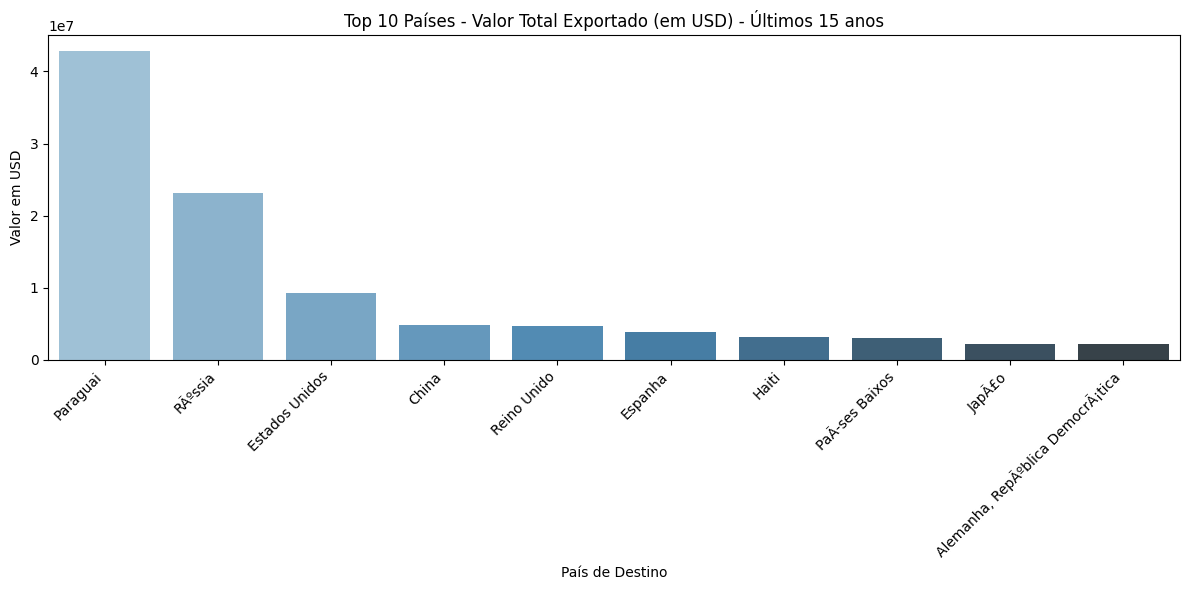

In [12]:
# Etapa 3: Análise descritiva
# Agrupar os dados por País e somar a quantidade e o valor
resumo_paises = dados_final.groupby('Pais').agg({
    'Quantidade_Litros': 'sum',
    'Valor_USD': 'sum'
}).reset_index()

# Remover países com valores de exportação zerados
resumo_paises = resumo_paises[(resumo_paises['Quantidade_Litros'] > 0) & (resumo_paises['Valor_USD'] > 0)]

# Ordenar pelos maiores valores exportados
# Ordenar os dados pelos maiores valores exportados
resumo_paises = resumo_paises.sort_values(by='Valor_USD', ascending=False)

# Filtrar os Top 10 países com maior valor exportado
top_paises = resumo_paises.head(10)

# Gráfico de barras: Valor exportado por país (Top 10)
plt.figure(figsize=(12, 6))
sns.barplot(x='Pais', y='Valor_USD', data=top_paises, palette='Blues_d')

# Configurações do gráfico
plt.title('Top 10 Países - Valor Total Exportado (em USD) - Últimos 15 anos')
plt.ylabel('Valor em USD')
plt.xlabel('País de Destino')
plt.xticks(rotation=45, ha='right')  # Rotacionar os rótulos no eixo X
plt.tight_layout()
plt.show()

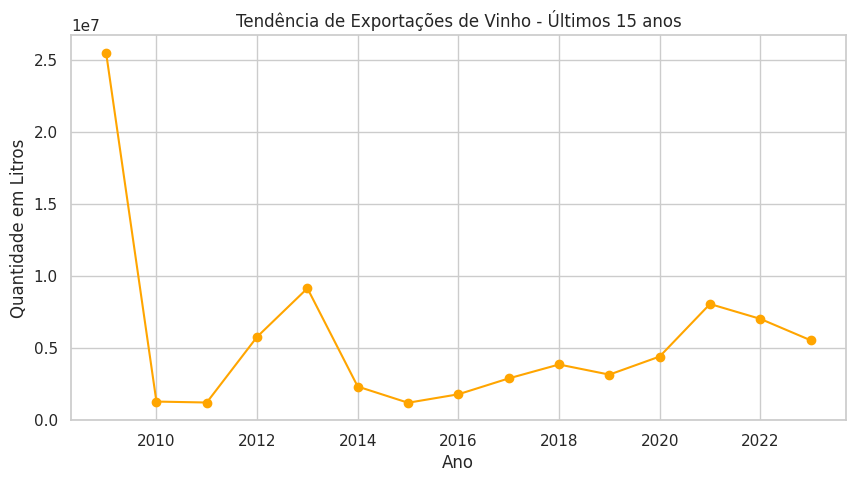

In [14]:
# Gráfico de linha: Tendência temporal de exportações
plt.figure(figsize=(10, 5))
dados_ano = dados_final.groupby('Ano').agg({'Quantidade_Litros': 'sum'}).reset_index()

plt.plot(dados_ano['Ano'], dados_ano['Quantidade_Litros'], marker='o', linestyle='-', color='orange')
plt.title('Tendência de Exportações de Vinho - Últimos 15 anos')
plt.xlabel('Ano')
plt.ylabel('Quantidade em Litros')
plt.grid(True)
plt.show()

Projeção para os próximos 5 anos:
Ano 2024: 2978394.06 Litros
Ano 2025: 2657568.34 Litros
Ano 2026: 2336742.62 Litros
Ano 2027: 2015916.90 Litros
Ano 2028: 1695091.19 Litros


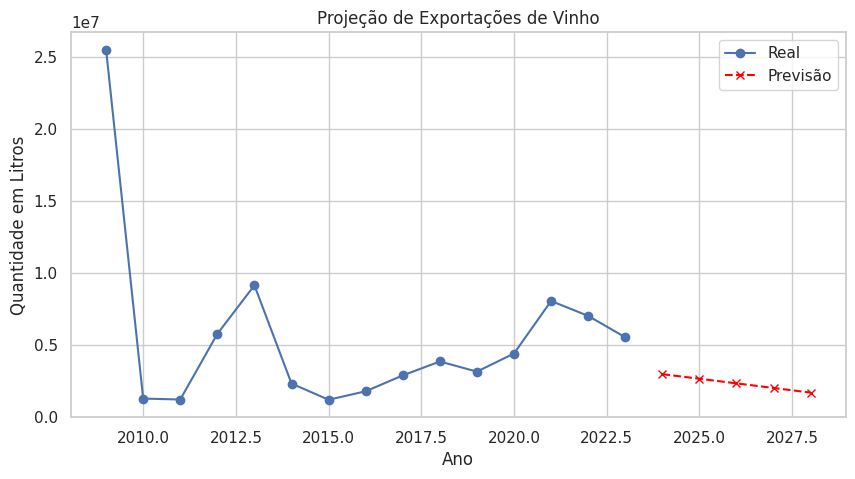

In [15]:
# Etapa 5: Projeção futura (modelo linear simples)
# Preparar os dados para o modelo
X = dados_ano['Ano'].values.reshape(-1, 1)
y = dados_ano['Quantidade_Litros'].values

# Aplicar regressão linear
modelo = LinearRegression()
modelo.fit(X, y)

# Prever valores futuros (próximos 5 anos)
anos_futuros = np.array([max(dados_ano['Ano']) + i for i in range(1, 6)]).reshape(-1, 1)
previsoes = modelo.predict(anos_futuros)

# Exibir resultados de previsão
print("Projeção para os próximos 5 anos:")
for ano, previsao in zip(anos_futuros.flatten(), previsoes):
    print(f"Ano {ano}: {previsao:.2f} Litros")

# Gráfico com projeções futuras
plt.figure(figsize=(10, 5))
plt.plot(dados_ano['Ano'], dados_ano['Quantidade_Litros'], label='Real', marker='o')
plt.plot(anos_futuros, previsoes, label='Previsão', linestyle='--', marker='x', color='red')
plt.title('Projeção de Exportações de Vinho')
plt.xlabel('Ano')
plt.ylabel('Quantidade em Litros')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# Agrupar os dados por país e somar os valores exportados
resumo_paises = dados_final.groupby('Pais').agg({
    'Quantidade_Litros': 'sum',
    'Valor_USD': 'sum'
}).reset_index()

# Filtrar apenas os países com valores positivos
resumo_paises = resumo_paises[resumo_paises['Valor_USD'] > 0]

# Criar o mapa de calor geoespacial com Plotly
fig = px.choropleth(
    resumo_paises,
    locations='Pais',              # Nome dos países
    locationmode='country names',  # Modo baseado nos nomes dos países
    color='Valor_USD',             # Coluna usada para a escala de cores
    title='Exportação de Vinhos do Brasil por País (em USD)',
    color_continuous_scale='Blues', # Paleta de cores
    labels={'Valor_USD': 'Valor (USD)'}
)

# Ajustar layout do gráfico
fig.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='natural earth'
    )
)

# Mostrar o gráfico
fig.show()